In [1]:
#MCMC FIT TO HST DATA INCLUDING BOTH ERI II AND CLUSTER, BINNED BY 30 PIXELS, AND MASKED 
#APPROPRIATELY
#PLUMMER PROFILE FOR ERI II, SERSIC PROFILE FOR CLUSTER
#UPDATED TO FIT ALL MODEL PARAMETERS INSTEAD OF JUST RICHNESS AND CENTER POSITION
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from astropy import wcs
from astropy.io import fits
# from matplotlib.mlab import rec2csv

import emcee
import corner

# from astropy.io import ascii
import _pickle as cPickle

In [3]:
f = fits.open('/Volumes/Samsung_T5/photRun0520/PEGASUS-III_f606w/final_drcF606W.fits',names=True)
w = wcs.WCS(f[1].header)

In [5]:
cat = np.genfromtxt('/Volumes/Samsung_T5/photRun0520/drcPhot29Apr/catDir_PEGASUS-III/PEGASUS-III_fullCat.dat',
                    names=True)


In [6]:
good = np.logical_and(np.logical_and(cat['magr_f606w']<=30,
                                     cat['magr_f606w']-cat['magr_f814w']<=0),
                      np.logical_or(cat['six_4_flag_f606w'] == 1,
                       cat['six_4_flag_f814w'] == 1))
# good = np.logical_or(cat['six_4_flag_f606w'] == 1,
#                        cat['six_4_flag_f814w'] == 1)

#                     cat['magRaw_v']<26)

# good = np.logical_and(cat['class_Star_i']>=0.8,
#                       cat['class_Star_v']>=0.8)

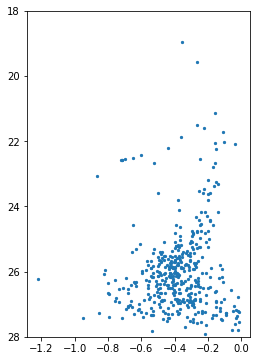

In [10]:
fig, ax = plt.subplots(figsize=(4,6))

ax.scatter(cat['magr_f606w'][good]-cat['magr_f814w'][good],cat['magr_f606w'][good],
          s=5)

ax.set_ylim(28,18)

plt.show()

In [5]:
xgood = cat['xcenter_f606w'][good]
ygood = cat['ycenter_f606w'][good]

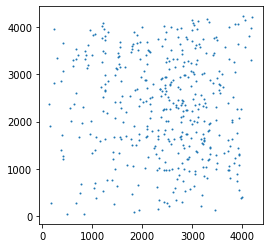

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(xgood,ygood,s=1)


plt.show()


In [7]:
orientat = -106.8615917223524

In [8]:
theta = np.deg2rad(orientat)
c,s = np.cos(theta), np.sin(theta)

In [9]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [222, 4043], 
	[1, 1], 
	[4096, 101], 
	[4217, 4245], 
	[222, 4043]])

GAP = Path([ [100, 2079], 
	[106, 2034], 
	[4156, 2183], 
	[4151, 2231], 
	[100, 2079]])



IMG_BIT = 0b01
GAP_BIT = 0b10

In [10]:
xpath = np.array([222,1,4096,4217,222])
ypath = np.array([4043,1,101,4245,4043])

xgap = np.array([100,106,4156,4151,100])
ygap = np.array([2079,2034,2183,2231,2079])

In [11]:
xstar1 = np.array([2267,1862,1862,2640,2640,1862])
ystar1 = np.array([813,829,823,823,829,829])

xstar2 = np.array([2263,2250,2264,2276,2263])
ystar2 = np.array([1183,501,492,1178,1183])

#ADD HIGHLY SATURATED STAR IN THE WEST TO MASK
# satstar_xcen = 2267
# satstar_ycen = 813
# near_satstar = np.where( np.sqrt((XX - satstar_xcen)**2 + (YY - satstar_ycen)**2) < 84)

# DIFF_SPIKES_EW = Path([ [1862, 829], 
# 	[1862, 823], 
# 	[2640, 823], 
# 	[2640, 829], 
# 	[1862, 829]])

# DIFF_SPIKES_NS = Path([ [2263, 1183], 
#     [2250, 501], 
# 	[2264, 492], 
# 	[2276, 1178], 
# 	[2263, 1183]])

In [12]:
coords = np.vstack((xgood,ygood))

In [13]:
coords.T.shape

(419, 2)

In [14]:
test = w.wcs_pix2world(coords.T,0)

In [15]:
c2 = np.vstack((336.1020000,5.4050000))

In [16]:
test2 = w.wcs_world2pix(c2.T,0)

In [17]:
test2

array([[2521.74038585, 2390.59489875]])

In [18]:
x0 = 2523.17585813
y0 = 2395.41373595

In [19]:
xpT = c*(xpath-x0) - s*(ypath-(y0)) + x0
ypT = s*(xpath-x0) + c*(ypath-(y0)) + (y0)
xgT = c*(xgap-x0) - s*(ygap-(y0)) + x0
ygT = s*(xgap-x0) + c*(ygap-(y0)) + (y0)
xT = c*(xgood-x0) - s*(ygood-(y0)) + x0
yT = s*(xgood-x0) + c*(ygood-(y0)) + (y0)

In [20]:
xsT1 = c*(xstar1-x0) - s*(ystar1-(y0)) + x0
ysT1 = s*(xstar1-x0) + c*(ystar1-(y0)) + (y0)

xsT2 = c*(xstar2-x0) - s*(ystar2-(y0)) + x0
ysT2 = s*(xstar2-x0) + c*(ystar2-(y0)) + (y0)


In [21]:
print(xsT1)
print(ysT1)
print(xsT2)
print(ysT2)

[1083.09942707 1215.88615356 1210.14410412  984.47685814  990.21890759
 1215.88615356]
[3099.57222288 3482.51958907 3484.25995343 2739.70754152 2737.96717715
 3482.51958907]
[1438.35271935  789.44388808  776.76996372 1429.79688869 1438.35271935]
[2996.07778668 3206.34030996 3195.55274113 2985.08698318 2996.07778668]


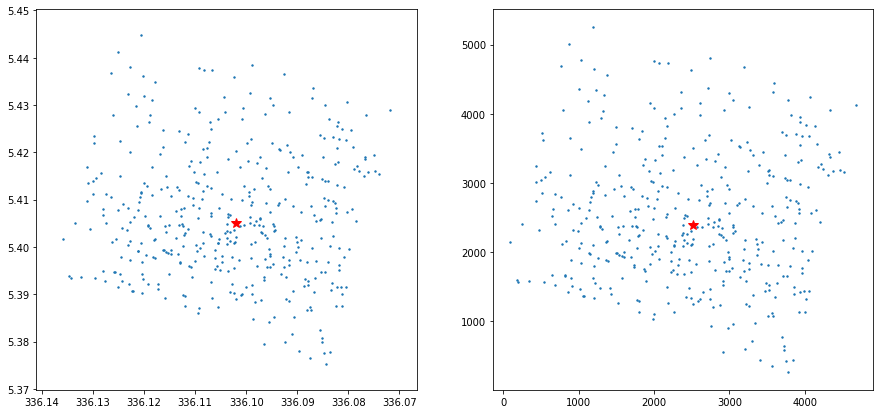

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.scatter(test[:,0],test[:,1],s=2)
ax1.plot(336.1020000,5.4050000,marker='*',color='red',ms=10)
ax2.plot(x0,y0,marker='*',color='red',ms=10)
ax2.scatter(xT,yT,s=2)

ax1.invert_xaxis()

plt.show()

In [23]:
len(xgood)

419

In [24]:
xgood = xT
ygood = yT

In [25]:
print(xpT)
print(ypT)

[4767.41023494  963.28634341 -128.81151146 3801.93329345 4767.41023494]
[4119.75792708 5503.68220893 1555.72738707  237.91773518 4119.75792708]


In [26]:
print(xgT)
print(ygT)

[2923.23345731 2878.42772207 1846.27600378 1893.66270301 2923.23345731]
[4806.19220131 4813.5028846   894.40045797  885.26258426 4806.19220131]


In [27]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [4767, 4120], 
	[963, 5504], 
	[-129, 1556], 
	[3801, 238], 
	[4767, 4120]])

GAP = Path([ [2923,4806], 
	[2878,4813], 
	[1846,894], 
	[1893,885], 
	[2923,4806]])



IMG_BIT = 0b01
GAP_BIT = 0b10

In [28]:
# keep = cat['six_4_flag_f606w'] == 1
# keep2 = np.logical_and(cat['six_4_flag_f606w'] == 1,
#                        cat['six_4_flag_f814w'] == 1)
# keep3 = np.logical_or(cat['six_4_flag_f606w'] == 1,
#                        cat['six_4_flag_f814w'] == 1)

In [29]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,7),sharex=True,sharey=True)

# ax1.scatter(cat['magr_f606w']-cat['magr_f814w'],cat['magr_f606w'],s=5)
# ax2.scatter(cat['magr_f606w'][keep3]-cat['magr_f814w'][keep3],cat['magr_f606w'][keep3],s=5)
# ax2.scatter(cat['magr_f606w'][keep]-cat['magr_f814w'][keep],cat['magr_f606w'][keep],s=5)
# ax2.scatter(cat['magr_f606w'][keep2]-cat['magr_f814w'][keep2],cat['magr_f606w'][keep2],s=5)


# ax1.set_ylim(28,20)
# ax1.set_xlim(-1.5,0.5)

# plt.subplots_adjust(wspace=0)
# plt.show()

In [30]:
print(min(xgood))
print(max(xgood))

print(min(ygood))
print(max(ygood))

93.90805285477654
4683.695373157745
263.5276731109675
5259.707433587101


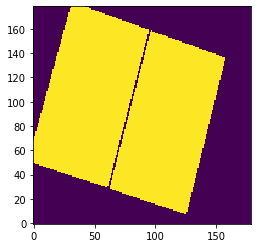

In [31]:
#DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
NBINS = 180
XMIN,XMAX = 0,5400
YMIN,YMAX = 0,5400
XEDGE = np.linspace(XMIN,XMAX,NBINS)
YEDGE = np.linspace(XMIN,XMAX,NBINS)

#BIN CENTERS
XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
#BIN SIZE
XDEL = XEDGE[1]-XEDGE[0]
YDEL = YEDGE[1]-YEDGE[0]

# Pre-calculate these instead of doing it in each evaluation of the model...
XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


#USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
#REQUIRES FLATTENING THE ARRAYS
MASK = np.zeros((NBINS-1,NBINS-1))
image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
plt.imshow(MASK.T,origin='lower')

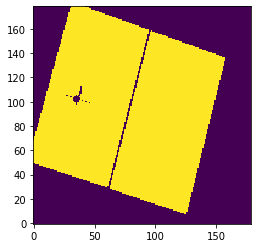

In [32]:
# [1083.09942707 1215.88615356 1210.14410412  984.47685814  990.21890759 1215.88615356]
# [3099.57222288 3482.51958907 3484.25995343 2739.70754152 2737.96717715 3482.51958907]

# [1438.35271935  789.44388808  776.76996372 1429.79688869 1438.35271935]
# [2996.07778668 3206.34030996 3195.55274113 2985.08698318 2996.07778668]

#ADD HIGHLY SATURATED STAR IN THE WEST TO MASK
satstar_xcen = 1083
satstar_ycen = 3100
near_satstar = np.where( np.sqrt((XX - satstar_xcen)**2 + (YY - satstar_ycen)**2) < 84)

DIFF_SPIKES_EW = Path([ [1216,3483], 
	[1210,3284], 
	[984,2749], 
	[990,2738], 
	[1216,3483]])

DIFF_SPIKES_NS = Path([ [1438,2996], 
    [789,3206], 
	[777,3196], 
	[1430,2985], 
	[1438,2996]])

MASK[near_satstar] = 0

spikes_mask_ew = DIFF_SPIKES_EW.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ew = np.where(spikes_mask_ew==1) # Array indices
MASK[masked_indices_spikes_ew] = 0

spikes_mask_ns = DIFF_SPIKES_NS.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ns = np.where(spikes_mask_ns==1) # Array indices
MASK[masked_indices_spikes_ns] = 0
plt.imshow(MASK.T,origin='lower')

In [33]:
from scipy.stats import gaussian_kde

In [34]:
xy = np.vstack([xgood,ygood])
z = gaussian_kde(xy)(xy)

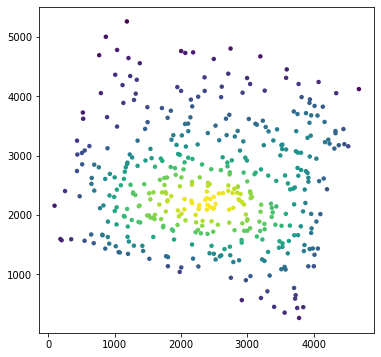

In [35]:
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(xgood, ygood, c=z, s=20, edgecolor='')
# ax.plot(0,0,color='red',ms=10,marker='*')

# hor_x0 = 2149
# hor_y0 = 2372
plt.show()


In [36]:
#DEFINE INITIAL MODEL PARAMETERS FOR peg3 II
peg3_NSTAR = 500 
#peg3_LON = 56.0888               # RA (deg)
#peg3_LAT = -43.5304              # Dec (deg)
peg3_X0 = 2500                   # X Center (pix)
peg3_Y0 = 2400                   # Y Center (pix)
peg3_EXT = 1.0/60.               # Extension (deg) # radius in arcminutes
# peg3_EXT_PIX = peg3_EXT*(3600/0.05) 
peg3_EXT_PIX = 2000
peg3_ELL = 0.3                 # Ellipticity
peg3_PA = 100              # Position angle (deg)
peg3_BG = 0.001

In [37]:
peg3_EXT_PIX

2000

In [38]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [39]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[XEDGE,YEDGE])
    return data_counts

In [40]:
def new_kernel(x,y,lon=peg3_X0,lat=peg3_Y0,ext=peg3_EXT_PIX,ell=peg3_ELL,pa=peg3_PA):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [41]:
def new_kernel_plummer(x,y,lon=peg3_X0,lat=peg3_Y0,ext=peg3_EXT_PIX,ell=peg3_ELL,pa=peg3_PA):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [42]:
def model(theta_peg3):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_peg3[0]
    kwargs = dict(lon=theta_peg3[1],lat=theta_peg3[2],ext=theta_peg3[3],ell=theta_peg3[4],pa=theta_peg3[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    sigma_bg = theta_peg3[6]
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel(XX,YY,**kwargs)

#     pdf = new_kernel(XX,YY,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = XDEL*YDEL
    model_counts = richness * pdf * pixarea + sigma_bg
    return model_counts

In [43]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED
    theta_peg3 = theta
    
    #commenting out to see if this will run
#     theta_cluster = theta[6:]
    
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_peg3 = model(theta_peg3)
    
    #ditto
#     model_counts_cluster = model_cluster(theta_cluster)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_peg3
    model_counts = model_counts_peg3 #+ model_counts_cluster

    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
    data_counts_masked = data_counts[IDX]
    model_counts_masked = model_counts[IDX]
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [44]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER
    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT
    
    rich1,lon1,lat1,ext1,ell1,pa1,bg1 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6]

    if not (50 < rich1 < 5000):  return np.inf
    if not (1500 < lon1 < 3500): return np.inf
    if not (1800 < lat1 < 3500): return np.inf
    if not (500 < ext1 < 7500): return np.inf
    if not (0.01 < ell1 < 0.9): return np.inf
    if not (60 < pa1 < 130): return np.inf
    if not (0 < bg1 < 0.02): return np.inf

    return 0

In [45]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...


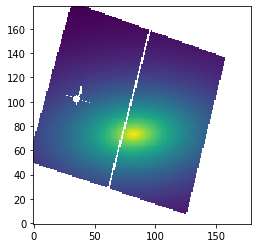

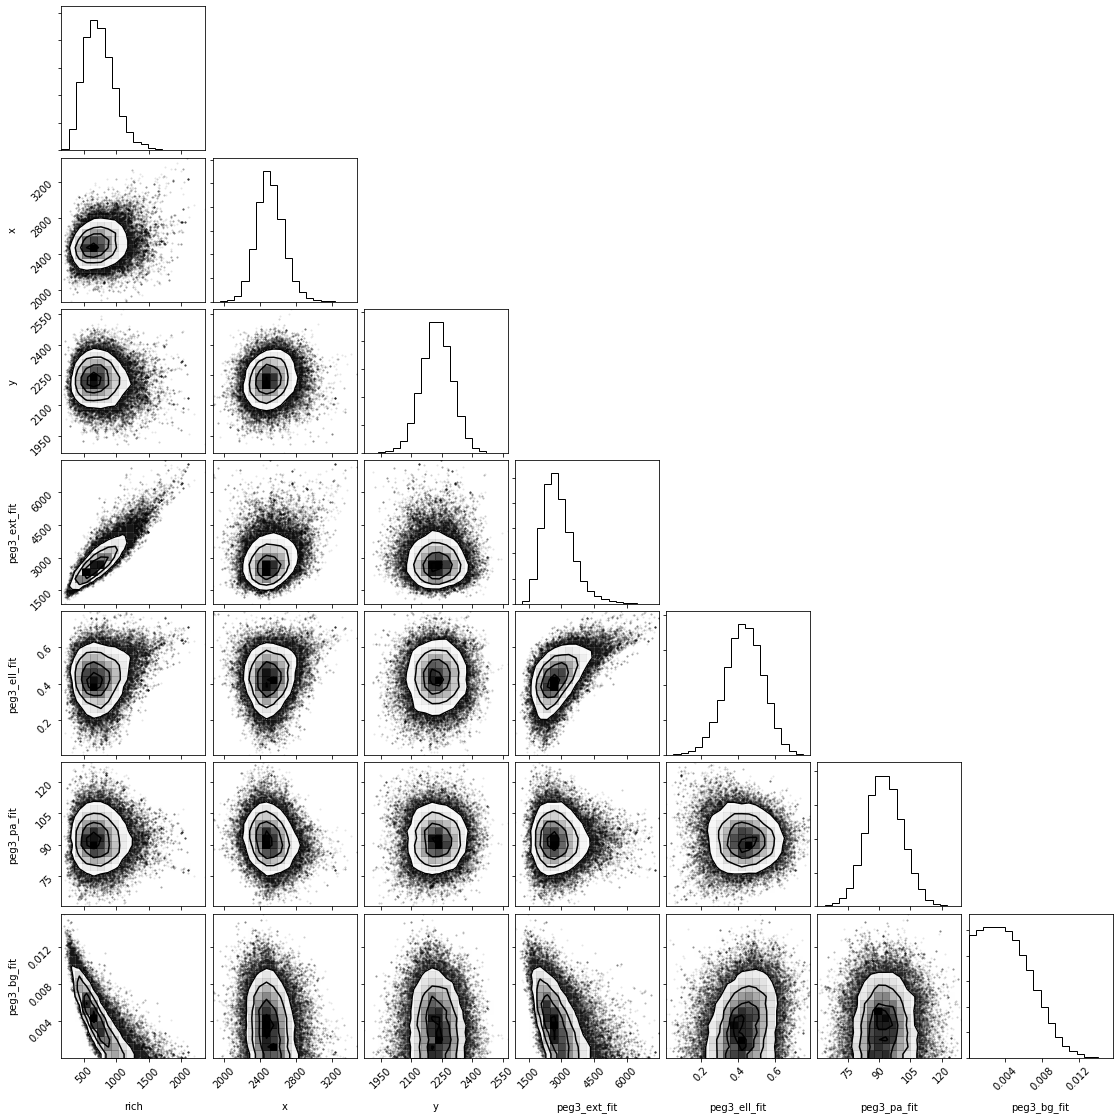

In [47]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=True

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
THETA = [peg3_NSTAR,peg3_X0,peg3_Y0,peg3_EXT_PIX,peg3_ELL,peg3_PA,peg3_BG]


#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
#     out_masked_counts = data_counts_masked
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_Peg3d_exp17.png')
     
    
    # Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 2000
nburn = 750
pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
peg3_ext_fit,[peg3_ext_min,peg3_ext_max] = median_interval(samples[:,3])
peg3_ell_fit,[peg3_ell_min,peg3_ell_max] = median_interval(samples[:,4])
peg3_pa_fit,[peg3_pa_min,peg3_pa_max] = median_interval(samples[:,5])
peg3_bg_fit,[peg3_bg_min,peg3_bg_max] = median_interval(samples[:,6])



if do_plot:
    theta_peg3 = [rich,x,y,peg3_ext_fit,peg3_ell_fit,peg3_pa_fit,peg3_bg_fit]
    model_counts_peg3 = model(theta_peg3)
    model_counts = model_counts_peg3 
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_Peg3d_exp17.png')

#CORNER PLOT    
    fig = corner.corner(samples, labels=["rich", "x", "y", "peg3_ext_fit", "peg3_ell_fit", 
                                         "peg3_pa_fit","peg3_bg_fit"])
    if save_plot:
        fig.savefig("trianglePeg3d_exp17.png")


In [63]:
print(peg3_bg_fit)

0.00407275585520963


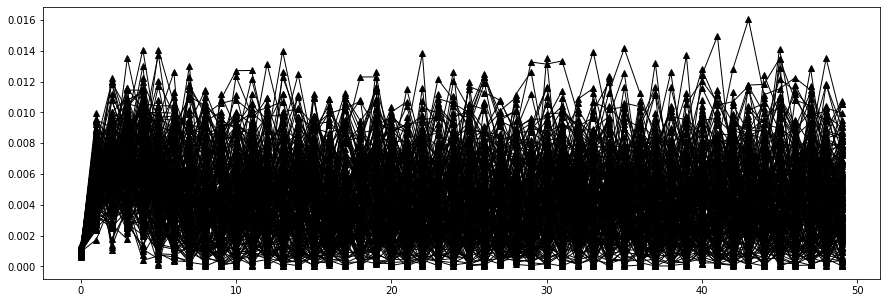

In [64]:
fig,ax = plt.subplots(figsize=(15,5))

for i in range(0,nwalkers-1):
    ax.plot(sampler.chain[i,:,6][::50],linewidth=1,color='black',marker='^',linestyle=None)

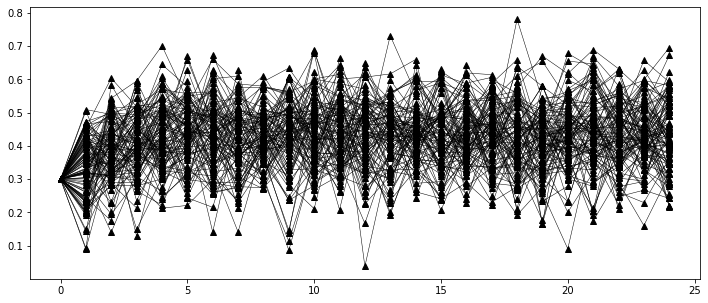

In [58]:
fig,ax = plt.subplots(figsize=(12,5))

for i in range(0,nwalkers-1):
    ax.plot(sampler.chain[i,:,4][::100],linewidth=0.5,color='black',marker='^',linestyle=None)

In [48]:
cPickle.dump(samples, open( "peg3mcmc3d_exp17.p", "wb" ) )

In [49]:
conv = 0.05/60 # pix to arcmin

In [50]:
res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
       peg3_ext_fit*conv,peg3_ext_max*conv-peg3_ext_fit*conv,peg3_ext_fit*conv-peg3_ext_min*conv,
           peg3_ell_fit,peg3_ell_max-peg3_ell_fit,peg3_ell_fit-peg3_ell_min,
       peg3_pa_fit,peg3_pa_max-peg3_pa_fit,peg3_pa_fit-peg3_pa_min,
      peg3_bg_fit,peg3_bg_max-peg3_bg_fit,peg3_bg_fit-peg3_bg_min]

# print(res)

print('Rich:',rich,rich_max-rich,rich-rich_min)
print('X:',x,xmax-x,x-xmin)
print('Y:',y,ymax-y,y-ymin)
print('Ext (arcmin)',peg3_ext_fit*conv,peg3_ext_max*conv-peg3_ext_fit\
          *conv,peg3_ext_fit*conv-peg3_ext_min*conv)
print('Ell:',peg3_ell_fit,peg3_ell_max-peg3_ell_fit,peg3_ell_fit-peg3_ell_min)
print('PA:',peg3_pa_fit,peg3_pa_max-peg3_pa_fit,peg3_pa_fit-peg3_pa_min)
print('BG:',peg3_bg_fit,peg3_bg_max-peg3_bg_fit,peg3_bg_fit-peg3_bg_min)


Rich: 712.6676401959185 253.95840466284994 207.45417697076698
X: 2498.2130645219067 152.37878041522617 137.51773380663235
Y: 2225.6953071121825 73.7848834559054 73.92661543890563
Ext (arcmin) 2.2938082520899257 0.6337570424166103 0.47480306367971203
Ell: 0.434045377086841 0.1013268910328321 0.10227785928264665
PA: 92.34501601378543 8.830670023054864 8.205812644815126
BG: 0.003894559259846144 0.0031034416264769846 0.002602817178825286


In [49]:
# bkg = stars/bin -> bin is 30 pix by 30 pix
# stars/pix**2 * (pix/arcsecond * arcsecond/arcmin)**2

In [50]:
peg3_bg_fit * (20**2) * (60**2) / 30**2

6.498881173137012

In [215]:
outArr = np.array([xgood,ygood])

In [217]:
np.savetxt('peg3xyGood.dat',outArr.T,header='xgood ygood')

In [51]:
cent = np.vstack((x,y))
radec = w.wcs_pix2world(cent.T,0)
print(radec)

[[336.1040658   5.4060839]]


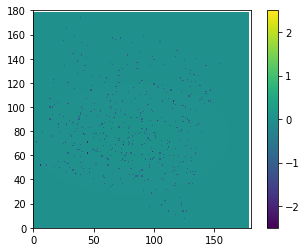

In [52]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(0,180)
plt.ylim(0,180)
plt.clim(-2.5,2.5)

In [53]:
break # 336.1020000,5.4050000; 
# x0 = 2523.17585813
# y0 = 2395.41373595

SyntaxError: 'break' outside loop (<ipython-input-53-6889e108a2bd>, line 4)

In [ ]:
5400/80

In [55]:
xbin0 = np.ones((180,1))  # (fltarr(80)+1)
xbin1 = np.ones((1,180))  
xbin1[0] = np.arange(0,180,1)
xbin2 = xbin1 * 30 + 0.5*(30)  # 67.5 pixels wide
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [56]:
costh = np.cos(-1 * np.deg2rad(peg3_pa_fit))
sinth = np.sin(-1 * np.deg2rad(peg3_pa_fit))

dx = xbin - x0
dy = ybin - y0

In [57]:
r1 = (dx * costh - dy * sinth) / (1 - peg3_ell_fit)
r2 = (dx * sinth + dy * costh)

radius = np.sqrt(r1**2 + r2**2)
# calculating distances to different bins in the annuli based on the PA

In [58]:
r_h = peg3_ext_fit

In [60]:
 # Exponential radius (re = rh/1.68)
r_e = r_h/1.68 
#Normalization (integrates to unity over all space) [stars/pix^2)
norm = 1./(2*np.pi*r_e**2 * (1-peg3_ell_fit) )

# Exponential PDF
pdf = norm * np.exp(-radius/r_e)

In [57]:
# Plummer
# r_h = peg3_ext_fit
# norm = r_h**2 / (np.pi * (1-peg3_ell_fit))
# # half light radius squared / (pi * 1-ell)
# pdf = norm/((radius**2 + r_h**2)**2)

In [61]:
xdel = 30
ydel = 30
pixarea = xdel*ydel  # pixel area in each bin

In [62]:
model_counts_gal = rich*pdf*pixarea

In [63]:
# Observed surface density map
binned_surface_density_30 = np.zeros((180,180))
for ii in range(180):
    for jj in range(180):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [64]:
# Define annuli
radius1 = radius.flatten()
r1 = (radius1 < (0.1 * r_h)).nonzero()
r2 = ((radius1 < (0.2 * r_h)) & (radius1 >= (0.1 * r_h))).nonzero()
r3 = ((radius1 < (0.3 * r_h)) & (radius1 >= (0.2 * r_h))).nonzero()
r4 = ((radius1 < (0.4 * r_h)) & (radius1 >= (0.3 * r_h))).nonzero()
r5 = ((radius1 < (0.5 * r_h)) & (radius1 >= (0.4 * r_h))).nonzero()
r6 = ((radius1 < (0.6 * r_h)) & (radius1 >= (0.5 * r_h))).nonzero()
r7 = ((radius1 < (0.7 * r_h)) & (radius1 >= (0.6 * r_h))).nonzero()
r8 = ((radius1 < (0.8 * r_h)) & (radius1 >= (0.7 * r_h))).nonzero()
r9 = ((radius1 < (0.9 * r_h)) & (radius1 >= (0.8 * r_h))).nonzero()
r10 = ((radius1 < r_h) & (radius1 >= (0.9 * r_h))).nonzero()

In [65]:
# areas of annuli in arcmin**2
pix_per_arcsec=20

a1 = (np.pi*(r_h*0.1)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a2 = (np.pi*(r_h*0.2)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.1)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a3 = (np.pi*(r_h*0.3)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.2)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a4 = (np.pi*(r_h*0.4)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.3)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a5 = (np.pi*(r_h*0.5)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.4)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a6 = (np.pi*(r_h*0.6)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.5)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a7 = (np.pi*(r_h*0.7)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.6)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a8 = (np.pi*(r_h*0.8)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.7)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a9 = (np.pi*(r_h*0.9)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.8)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2
a10 = (np.pi*(r_h*1.0)**2*(1-peg3_ell_fit) - np.pi*(r_h*0.9)**2*(1-peg3_ell_fit))/(pix_per_arcsec*60)**2

In [66]:
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [67]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf = model_counts_gal.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1d = [binned_surface_density_30f[r1].sum()/a1,
           binned_surface_density_30f[r2].sum()/a2,
           binned_surface_density_30f[r3].sum()/a3,
           binned_surface_density_30f[r4].sum()/a4,
           binned_surface_density_30f[r5].sum()/a5,
           binned_surface_density_30f[r6].sum()/a6,
           binned_surface_density_30f[r7].sum()/a7,
           binned_surface_density_30f[r8].sum()/a8,
           binned_surface_density_30f[r9].sum()/a9,
           binned_surface_density_30f[r10].sum()/a10]

model_1d = [model_counts_galf[r1].sum()/a1,
            model_counts_galf[r2].sum()/a2,
            model_counts_galf[r3].sum()/a3,
            model_counts_galf[r4].sum()/a4,
            model_counts_galf[r5].sum()/a5,
            model_counts_galf[r6].sum()/a6,
            model_counts_galf[r7].sum()/a7,
            model_counts_galf[r8].sum()/a8,
            model_counts_galf[r9].sum()/a9,
            model_counts_galf[r10].sum()/a10]


In [68]:
import matplotlib as mpl

In [67]:
def plummer(radius,rich,r_h,ell):
    
    # Everything needs to be in pixel units
    
    term1 = rich / (np.pi * r_h**2 * (1-ell))
    term2 = (1 + (radius**2/r_h**2))**(-2)
    
    return term1 * term2

In [79]:
def exponential(radius,rich,r_h,ell):
    
    # Everything needs to be in pixel units
    r_e = r_h/1.68
    
    term1 =  rich / (2 * np.pi * r_e**2 * (1-ell))
    term2 = np.exp(-1*radius/r_e)
    
    return term1 * term2

In [ ]:
#stars/pixel^2 * (pixel/arcsec)**2 * (arcsec/arcmin)**2
# * (20)**2 * (60)**2

In [97]:
# ptest = plummer(dist_x*1200,rich,peg3_ext_fit,peg3_ell_fit)

In [80]:
exptest = exponential(dist_x*1200,rich,peg3_ext_fit,peg3_ell_fit)

In [81]:
bkg_add = peg3_bg_fit * (20**2) * (60**2) / 30**2

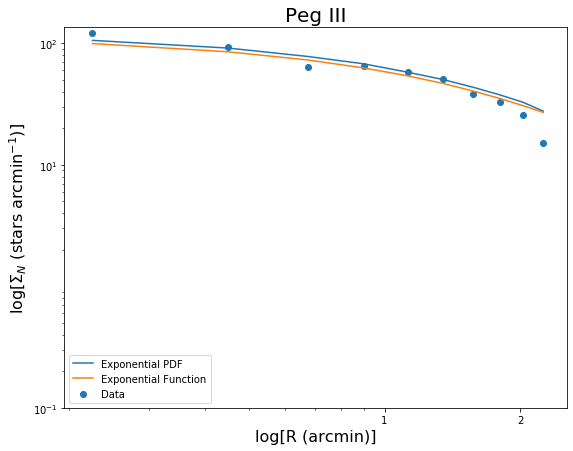

In [219]:
fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(dist_x,data_1d,label='Data')
ax.plot(dist_x,model_1d + bkg_add,label='Exponential PDF')
ax.plot(dist_x,exptest*(1200**2)+ bkg_add,label='Exponential Function')
# ax.plot(dist_x,model_1de,label='Model Exp')
# ax.hlines(bkg_add,1e-1,3)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-1}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Peg III',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_yticks([1e-1,1e1,1e+2])


ax.legend()
# plt.savefig('figures/sgr2.png')
plt.show()

In [ ]:
break

In [ ]:
fig, ax = plt.subplots()

ax.plot(ra1,data_1d,label='Data')
ax.plot(ra1,model_1d,label='Model')

ax.legend()
plt.show()

In [ ]:
filename='results_b%i_s%i_125p.csv'%(NBINS-1,nsamples)
results.tofile(filename,sep=',')

In [ ]:
#CHECK HOW LONG A BURN-IN IS NEEDED BEFORE FIT RESULTS STABILIZE
for i in range(0,nwalkers-1):
    plt.plot(sampler.chain[i,:,4],linewidth=1,color='black')

In [ ]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(70,170)
plt.ylim(70,170)
plt.clim(-2.5,2.5)

In [ ]:
def returnPDFp(rich,x0,y0,gal_ext_pix,gal_ell,gal_pa):
    
    costh = np.cos(-1 * np.deg2rad(gal_pa))
    sinth = np.sin(-1 * np.deg2rad(gal_pa))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    r_h = gal_ext_pix
    norm = r_h**2 / (np.pi * (1-gal_ell))
    # half light radius squared / (pi * 1-ell)
    pdf = norm/((radius**2 + r_h**2)**2)
    
    arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    r_annuli = (arr + 0.05) * r_h

    # .05r_h, .15r_h
    area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)
    
#     pix_per_arcsec=20
#     area_arcmin = area_annuli/(pix_per_arcsec*60)**2
    
    aa = area_annuli # trying. to do everything in pixel space right now

    return pdf, radius, aa


In [ ]:
def returnPDFe(rich,x0,y0,gal_ext_pix,gal_ell,gal_pa):
    
    costh = np.cos(-1 * np.deg2rad(gal_pa))
    sinth = np.sin(-1 * np.deg2rad(gal_pa))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    # Exponential radius (re = rh/1.68)
    r_e = gal_ext_pix/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)
    arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    r_annuli = (arr + 0.05) * r_h

    # .05r_h, .15r_h
    area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)
    
#     pix_per_arcsec=20
#     area_arcmin = area_annuli/(pix_per_arcsec*60)**2
    
    aa = area_annuli # trying. to do everything in pixel space right now

    return pdf, radius, aa
